# Conventional pole-based APWP

 APWP based on simulated VGPs (*pseudo*-VGPs) following the approach from Vaes et al. (2022)

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP, RM_stats
from vgptools.utils_visualization import  RM_stats, plot_pseudoVGPs_and_APWP, plot_APWP_RM_ensemble

Path to the VGP directory.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

## Generate a DataFrame for both, the VGPs and the recomputed poles by study

In doing so, we calculate a pole for each study taking into account all the vgps within the same area/study

In [3]:
df_filtered_vgps, df_pole_compilation_by_study = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True)

In [4]:
df_pole_compilation_by_study.head()

,Study,pole,N,K,A95,slat,slon,Plat,Plon,min_age,max_age,mean_age
0,Absaroka_volcanics,NaN,44,11.076771,6.774448,44.613899,250.051065,-81.917678,328.575930,45.0000,54.0000,49.5000
1,Beaver_River_intrusions,NaN,21,44.972756,4.792312,60.238151,234.652209,-79.313242,327.669841,40.5000,43.5000,42.0000
2,Bighorn_Basin_sediments,NaN,59,10.640570,5.954672,44.459816,251.809627,-81.549042,2.761738,52.5400,59.2370,55.8885
3,Bishop_tuff,NaN,47,127.000000,1.900000,37.670000,241.250000,-80.164116,314.290252,0.7661,0.7679,0.7670
4,Bitterroot_Dome_intrusions,NaN,19,7.231338,13.418646,46.190800,245.543303,-81.199091,61.199579,46.4000,55.5000,50.9500


# Moving average on parametrically resampled vgps ('pseudo vgps')

First we need to generate a new dataset by drawing parametrically from the study-level poles.

In the present formulation the age of each *pseudo*-VGPs, it is taken at random between
the lower and upper bounds of the distribution of reported VGPs.

In [5]:
def get_pseudo_vgps(df):  
    '''
    takes a DF with paleomagnetic poles and respective statistics, it draws N randomly generated VGPs
    following the pole location and kappa concentration parameter. In the present formulation we follow
    a very conservative apporach for the assignaiton of ages to each VGP, it is taken at random between
    the lower and upper bounds of the distribution of reported VGPs.
    Note: column labels are presently hard-coded into this, if relevant.
    '''
    Study, age_bst, vgp_lat_bst, vgp_lon_bst = [], [], [], []

    for index, row in df.iterrows():
        
        # we first generate N VGPs following with N the number of VGPs from the original pole.
        directions_temp = ipmag.fishrot(k = row.K, n = row.N, dec = row.Plon, inc = row.Plat, di_block = False)
        
        vgp_lon_bst.append(directions_temp[0])
        vgp_lat_bst.append(directions_temp[1])
    
        age_bst.append([np.random.randint(np.floor(row.min_age),np.ceil(row.max_age)) for _ in range(row.N)])
        Study.append([row.Study for _ in range(row.N)])
    
    vgp_lon_bst = [item for sublist in vgp_lon_bst for item in sublist]
    vgp_lat_bst = [item for sublist in vgp_lat_bst for item in sublist] 
    age_bst = [item for sublist in age_bst for item in sublist]
    Study = [item for sublist in Study for item in sublist]
    
    dictionary = {
                  'Study': Study,
                  'Plat': vgp_lat_bst,    
                  'Plon': vgp_lon_bst,
                  'mean_age': age_bst
                  }    
    
    pseudo_vgps = pd.DataFrame(dictionary)

    return pseudo_vgps

In [6]:
%%time
df_pseudo_vgps = get_pseudo_vgps(df_pole_compilation_by_study)
df_pseudo_vgps.head(3)

Wall time: 186 ms


,Study,Plat,Plon,mean_age
0,Absaroka_volcanics,-54.786479,340.412359,47
1,Absaroka_volcanics,-66.880554,2.052703,48
2,Absaroka_volcanics,-44.259481,149.336499,47


# Applying the running mean on the *pseudo*-VGPs
We first apply the running mean method with the same parameter as in Torsvik et al. 2012 - a window lenght of 20 Ma and a time-step of 10 Ma.

In [14]:
min_age = 0
max_age = 65
window_length = 18
time_step = 10

RM_on_pseudoVGP = running_mean_APWP (df_pseudo_vgps, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_on_pseudoVGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat
0,0.0,296.0,15.0,23.629018,1.717900,16.663345,296.457672,-87.659260
1,10.0,292.0,13.0,16.059014,2.120281,20.212758,314.262574,-88.691856
2,20.0,247.0,8.0,11.462890,2.766920,23.924229,351.645534,-82.468320


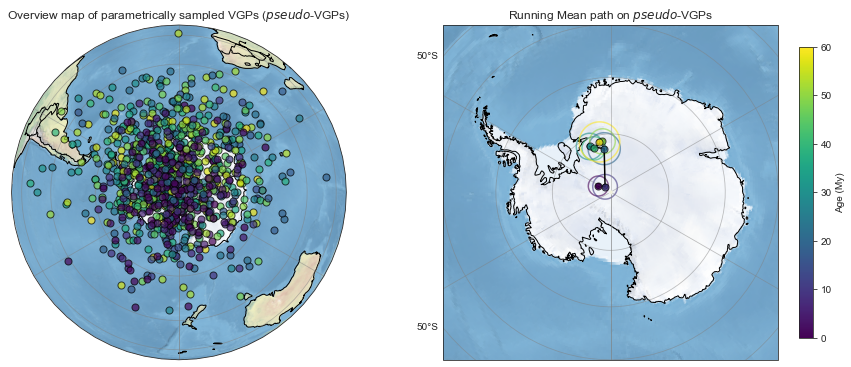

In [15]:
extent = [-180,180,-60,-60]
plot_pseudoVGPs_and_APWP(extent, df_pseudo_vgps, RM_on_pseudoVGP)

### Bootstrapped age distribution

<AxesSubplot:title={'center':'Bootstrapped age distribution'}, xlabel='Mean Age', ylabel='Number of $pseudo$-VGPs'>

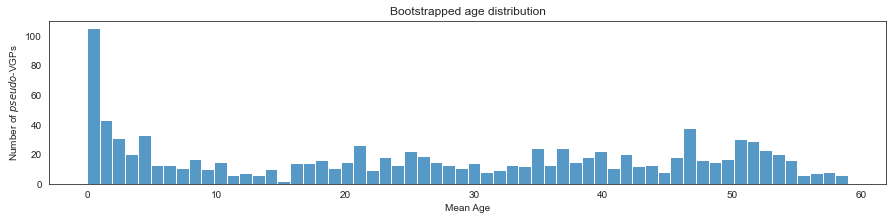

In [9]:
fig = plt.figure(figsize=(15,3))
plt.title('Bootstrapped age distribution')
plt.ylabel('Number of $pseudo$-VGPs')
plt.xlabel('Mean Age')
sns.histplot(data = df_pseudo_vgps, x = 'mean_age', bins = 60, legend = False) 

### Running Mean Statistics

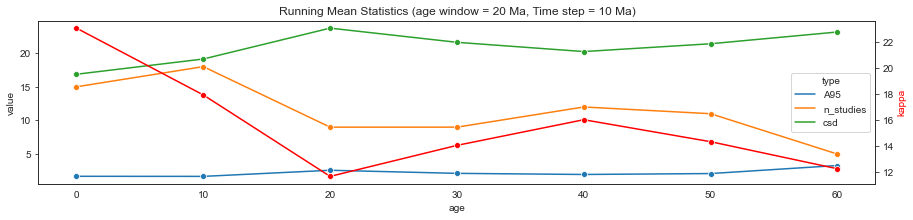

In [10]:
RM_stats(RM_on_pseudoVGP, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)","Age (Ma)","kappa")

# APWP confidence bounds

Because we are taking a Monte Carlo approach, confidence on the mean cannot be assessed from one iteration. To generate confidence bounds on the APWP, we will apply the same approach a number of times in order to construct an ensemble of possible solutions that will allow us to construct empirical confidence bounds.

In [11]:
%%time
df_parametric_means_collection = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):
    
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation_by_study)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    df_parametric_means_collection = df_parametric_means_collection.append(RM_APWP_parametric_temp, ignore_index=True)
    
df_parametric_means_collection = df_parametric_means_collection.astype(float)

Wall time: 20.3 s


In [12]:
df_parametric_means_collection.head(5)

,run,n_studies,k,A95,csd,age,N,plon,plat
0,0.0,15.0,22.390913,1.693733,17.117846,0.0,322.0,285.141137,-87.506102
1,0.0,18.0,20.170074,1.584774,18.035628,10.0,410.0,291.318241,-87.144072
2,0.0,9.0,12.922841,2.516294,22.532325,20.0,262.0,332.967829,-82.861811
3,0.0,9.0,13.463903,2.201710,22.074940,30.0,327.0,340.617810,-81.656498
4,0.0,12.0,16.767129,1.894592,19.781338,40.0,349.0,341.255704,-81.789555


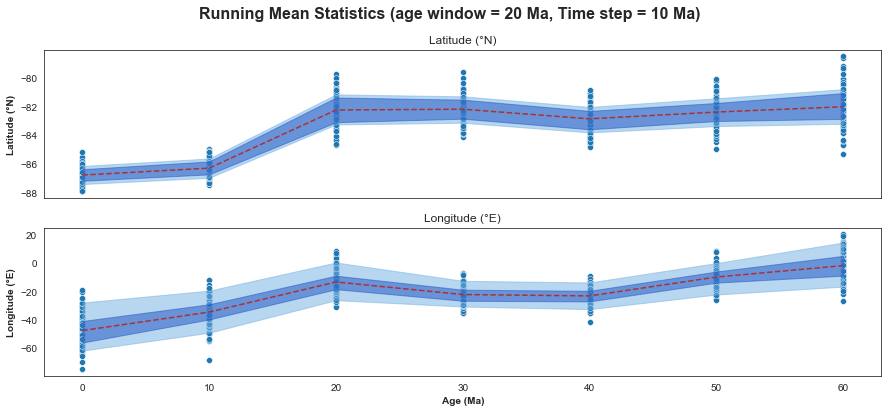

In [13]:
plot_APWP_RM_ensemble(df_parametric_means_collection, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)")